In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [2]:
df1 = pd.read_excel('liver.xlsx')
df2 = pd.read_excel('bile duct.xlsx')
df3 = pd.read_excel('gall bladder.xlsx')
df4 = pd.read_excel('other biliary.xlsx')

In [3]:
data = pd.concat([df1, df2, df3, df4], axis=0)
data = data.reset_index(drop=True)
data.head()

,Sex,Year,AgeGroup,Ethnicity,Race,Deaths,Population,Crude Rate,Survival Rate scaled,Survival Rate,Survival Rate scaled
0,Male,1999,35-39 years,Non-Hispanic,Asian or Pacific Islander,18,470141,3.8,0.965653,0.999962,NaN
1,Male,1999,35-39 years,Non-Hispanic,Black or African American,19,1334212,1.4,0.988513,0.999986,NaN
2,Male,1999,35-39 years,Non-Hispanic,White,28,8092269,0.3,0.998762,0.999997,NaN
3,Female,1999,40-44 years,Non-Hispanic,White,31,8131895,0.4,0.998427,0.999996,NaN
4,Male,1999,40-44 years,Hispanic,White,19,1051048,1.8,0.984866,0.999982,NaN


In [4]:
# Define the mappings
sex_mapping = {'Male': 0, 'Female': 1}
ethnicity_mapping = {'Hispanic': 1, 'Non-Hispanic': 0}
race_mapping = {'White': 1, 'Black or African American': 0, 'Asian or Pacific Islander': 2, 'American Indian or Alaska Native': 3}

In [5]:
# Replace the values using the mappings
data['Sex'] = data['Sex'].replace(sex_mapping)
data['Ethnicity'] = data['Ethnicity'].replace(ethnicity_mapping)
data['Race'] = data['Race'].replace(race_mapping)

# Define the mapping function for AgeGroup
def map_age_group(age_group):
    if age_group == '1-4 years':
        return 0
    elif age_group == '5-9 years':
        return 1
    elif age_group == '10-14 years':
        return 2
    elif age_group == '15-19 years':
        return 3
    elif age_group == '20-24 years':
        return 4
    elif age_group == '25-29 years':
        return 5
    elif age_group == '30-34 years':
        return 6
    elif age_group == '35-39 years':
        return 7
    elif age_group == '40-44 years':
        return 8
    elif age_group == '45-49 years':
        return 9
    elif age_group == '50-54 years':
        return 10
    elif age_group == '55-59 years':
        return 11
    elif age_group == '60-64 years':
        return 12
    elif age_group == '65-69 years':
        return 13
    elif age_group == '70-74 years':
        return 14
    elif age_group == '75-79 years':
        return 15
    elif age_group == '80-84 years':
        return 16
    elif age_group == '85+ years':
        return 17
    else:
        return 18

# Apply the mapping function to the AgeGroup column
data['AgeGroup'] = data['AgeGroup'].apply(map_age_group)


In [6]:
data

,Sex,Year,AgeGroup,Ethnicity,Race,Deaths,Population,Crude Rate,Survival Rate scaled,Survival Rate,Survival Rate scaled
0,0,1999,7,0,2,18,470141,3.8,0.965653,0.999962,NaN
1,0,1999,7,0,0,19,1334212,1.4,0.988513,0.999986,NaN
2,0,1999,7,0,1,28,8092269,0.3,0.998762,0.999997,NaN
3,1,1999,8,0,1,31,8131895,0.4,0.998427,0.999996,NaN
4,0,1999,8,1,1,19,1051048,1.8,0.984866,0.999982,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3815,0,2020,16,1,1,17,206889,8.2,NaN,0.999918,0.384857
3816,0,2020,16,0,1,102,2165315,4.7,NaN,0.999953,0.654097
3817,1,2020,17,1,1,19,316810,6.0,NaN,0.999940,0.555299
3818,1,2020,17,0,1,154,3312842,4.6,NaN,0.999954,0.658862


In [7]:
# Define features and target variables
features = ['Sex', 'Year', 'AgeGroup', 'Ethnicity', 'Race']
target = 'Crude Rate'

In [8]:
# Normalize the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()


data[features] = scaler_features.fit_transform(data[features])
joblib.dump(scaler_features, 'HPCscalerX.joblib')
data[[target]] = scaler_target.fit_transform(data[[target]])
joblib.dump(scaler_target, 'HPCscalerY.joblib')

['HPCscalerY.joblib']

In [9]:
# Access the 'Survival Rate' column
survival_rate_column = data['Survival Rate'].values

# Reshape the data to fit the scaler's requirements (if it's a single feature)
survival_rate_column = survival_rate_column.reshape(-1, 1)

# Initialize the MinMaxScaler
scaler_survivalrate = MinMaxScaler()

# Fit and transform the data
ss_rate_scaled = scaler_survivalrate.fit_transform(survival_rate_column)
joblib.dump(scaler_survivalrate, 'HPCscalerT.joblib')

['HPCscalerT.joblib']

In [10]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)


In [11]:
# Prepare the data for LSTM
def create_dataset(data, features, target, seq_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X_train, y_train = create_dataset(train_data, features, target, seq_length)
X_test, y_test = create_dataset(test_data, features, target, seq_length)

In [12]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Save the model
joblib.dump(model, 'HPCmodel.joblib')

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0337 - val_loss: 0.0490
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0277 - val_loss: 0.0051
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0192 - val_loss: 0.0140
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0169 - val_loss: 0.0090
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0141 - val_loss: 0.0164
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0147 - val_loss: 0.0055
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0124 - val_loss: 0.0067
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0109 - val_loss: 0.0062
Epoch 10/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0110 - val_loss: 0.0076
Epoch 11/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0101 - val_loss: 0.0196
Epoch 12/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0

In [14]:
# Inverse transform the predictions and actual values
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
y_train = scaler_target.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1))



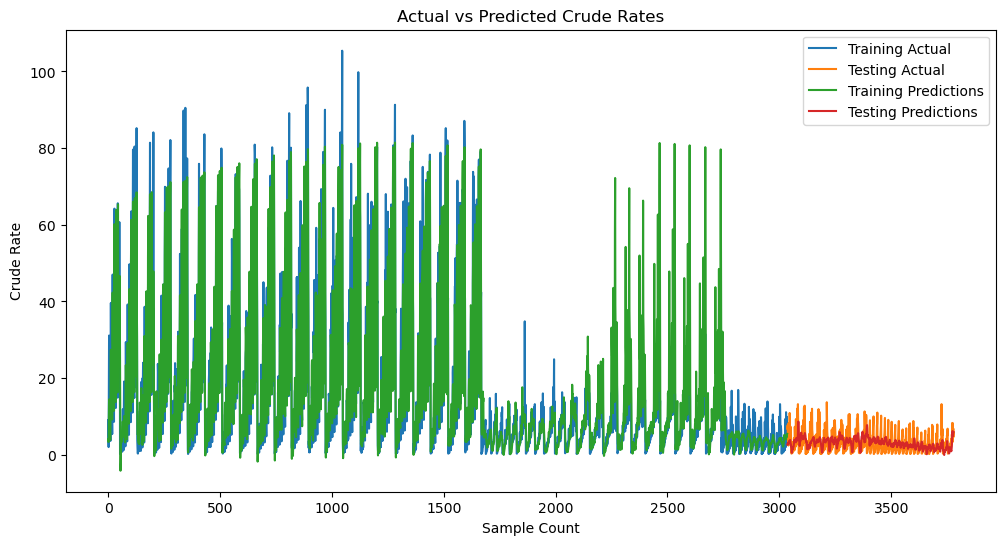

In [15]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Training Actual')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Testing Actual')
plt.plot(range(len(y_train)), train_predict, label='Training Predictions')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label='Testing Predictions')
plt.xlabel('Sample Count')
plt.ylabel('Crude Rate')
plt.legend()
plt.title('Actual vs Predicted Crude Rates')
plt.show()

In [16]:
# Function to predict future crude rate based on user input
def predict_future_crude_rate(model, user_input, scaler_features, scaler_target, seq_length=3):
    # Normalize user input
    user_input = scaler_features.transform([user_input])
    user_input = np.array([user_input for _ in range(seq_length)]).reshape(1, seq_length, -1)
    
    # Make prediction
    prediction = model.predict(user_input)
    prediction = scaler_target.inverse_transform(prediction)
    
    return prediction[0][0]

In [17]:

# Example usage: Predict future crude rate for a given user input
user_input = [1, 2008, 1, 0, 1]  # Replace with actual input
predicted_crude_rate = predict_future_crude_rate(model, user_input, scaler_features, scaler_target)
print(f"Predicted Crude Rate: {predicted_crude_rate}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 878ms/step
Predicted Crude Rate: 5.949458122253418
